<div style='background:#B1F9E3; color:#000000' class='alert alert-box'>
<h1>Watershed Delineation</h1>

In [1]:
%matplotlib inline

import numpy as np
from pysheds.rfsm import RFSM
from pysheds.grid import Grid

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading Dem File
grid = Grid.from_raster("DEM/n15_e075_1arc_v3.tif")
dem = grid.read_raster("DEM/n15_e075_1arc_v3.tif")

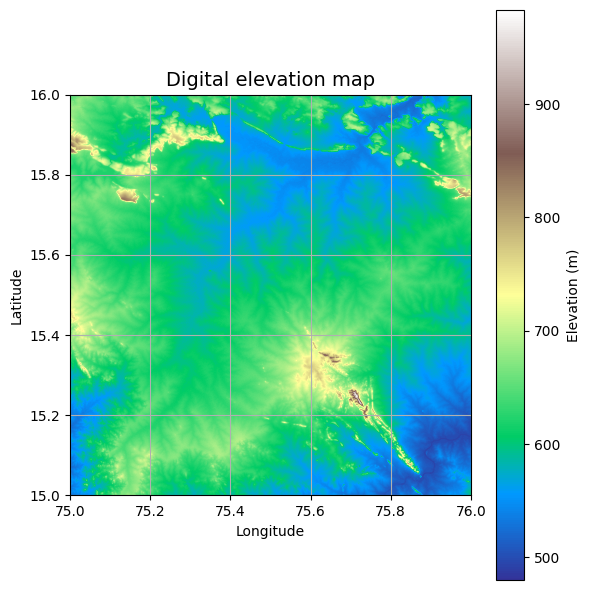

In [3]:
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [4]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

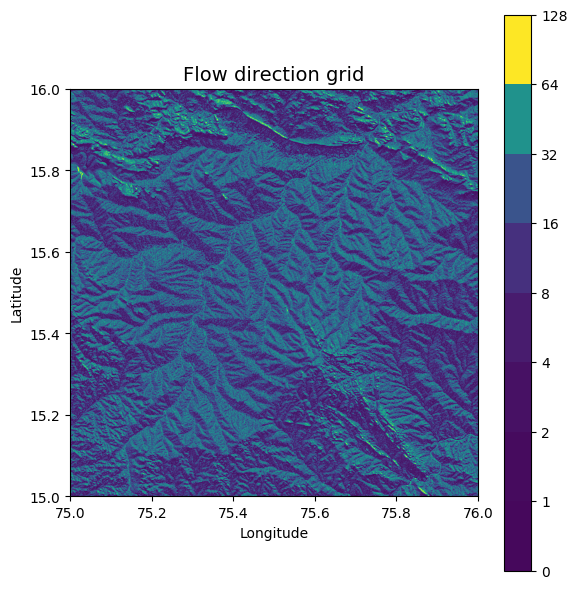

In [5]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [6]:
#Calculating flow accumulation
acc = grid.accumulation(fdir, dirmap=dirmap)

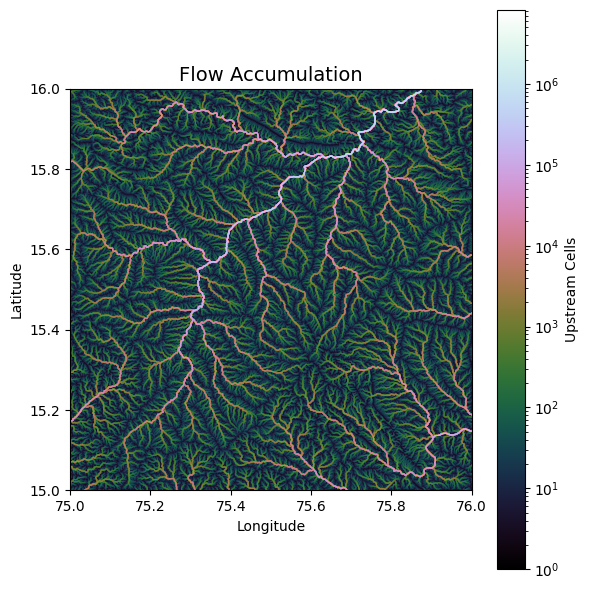

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [8]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = 75.756, 15.821

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

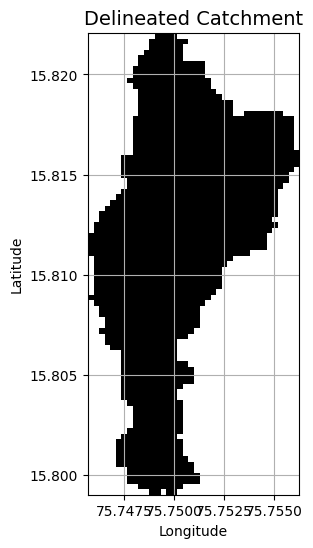

In [9]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

In [10]:
# Converting Catchment Raster to Vector

from shapely import geometry, ops
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape)
                                     for shape, value in shapes])

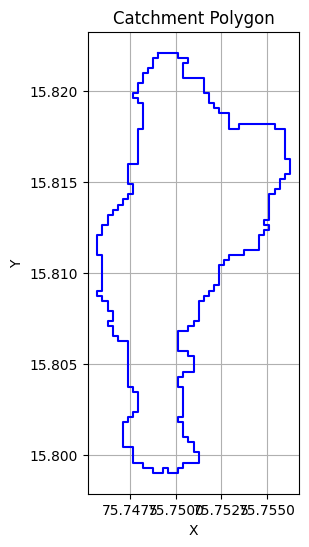

In [11]:
fig, ax = plt.subplots(figsize = (6,6))

# Check if the result is a GeometryCollection or MultiPolygon
if catchment_polygon.geom_type == 'GeometryCollection':
    for geom in catchment_polygon.geoms:
        if geom.geom_type == 'Polygon':
            x, y = geom.exterior.xy
            ax.plot(x, y, color='blue')
elif catchment_polygon.geom_type == 'MultiPolygon':
    for polygon in catchment_polygon.geoms:
        x, y = polygon.exterior.xy
        ax.plot(x, y, color='blue')
else:
    x, y = catchment_polygon.exterior.xy
    ax.plot(x, y, color='blue')

# Set aspect ratio to be equal
ax.set_aspect('equal', 'box')

plt.title("Catchment Polygon")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

<Axes: >

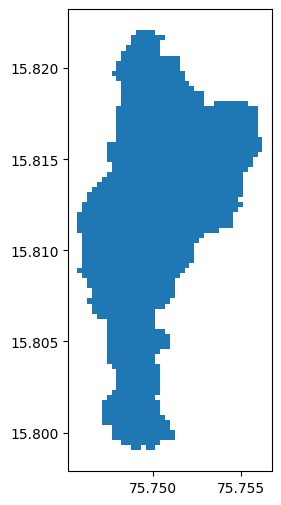

In [12]:
import geopandas as gpd
# Vectorization of Catchment Area
gdf_basin = gpd.GeoDataFrame(geometry=[catchment_polygon], crs=4326)
gdf_basin.plot(figsize=(6,6))

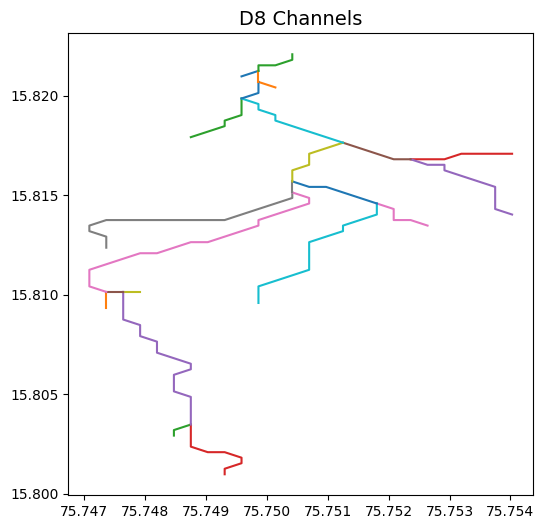

In [13]:
#Extraction of Stream Network
branches = grid.extract_river_network(fdir, acc > 40, dirmap=dirmap)

plt.figure(figsize=(6, 6))  # Set the figure size to 6x6 inches
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

plt.title('D8 Channels', size=14)
plt.show()

Text(0.5, 1.0, 'Stream Network')

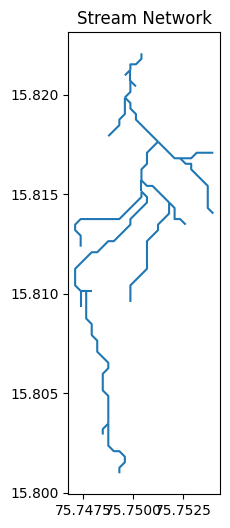

In [14]:
from shapely.geometry import LineString

# Extracting Stream Line Network geometry to list
lines = []
for branch in branches['features']:
        line = LineString(branch['geometry']['coordinates'])
        lines.append(line)
    
# Vectorization of Stream Network
stream_gdf = gpd.GeoDataFrame(geometry=lines)
stream_gdf.plot(figsize=(6,6))
plt.title('Stream Network')